In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.24.3
pandas version :  2.0.3
seaborn version :  0.12.2


In [2]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Load Dataset

In [3]:
datapre = pd.read_csv('Dataset/Product_Exclusive_Classification.csv')
datapre.head(2)

,id,brand,category,rating,number_of_reviews,love,price,value_price,exclusive
0,50,SEPHORA COLLECTION,no category,5.0,46.0,0.0,50.0,50.0,0
1,304,SEPHORA COLLECTION,no category,0.0,0.0,0.0,50.0,50.0,0


# Data Preparation

## Handle Missing Value

In [4]:
# function to check missing values

import pandas as pd

def info_missing_value(data):
    """
    Calculate missing data statistics and return the missing data DataFrame.

    Parameters:
        data (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame containing the missing data statistics.
    """

    # Calculate the total count of missing values for each column
    total = data.isna().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / len(data) * 100).sort_values(ascending=False)
    length = len(data)

    missing_data = pd.DataFrame(total, columns=['Total'])
    missing_data['Percent']     = percent
    missing_data['Data_length'] = length
    missing_data = missing_data[missing_data['Total']>0]

    return missing_data

In [5]:
info_missing_value(datapre)

,Total,Percent,Data_length
rating,95,1.1875,8000
love,34,0.4250,8000
value_price,17,0.2125,8000
category,13,0.1625,8000
number_of_reviews,9,0.1125,8000
price,8,0.1000,8000


It can be observed that, apart from the `id`, `brand`, and `exclusive` columns, there are rows with missing values. The number of missing values is not significant, accounting for a maximum of approximately 1-2% of the data. To handle this, we will perform imputation using the median for numerical columns and the mode for categorical columns. Imputing with the median is more relevant due to the skewed distribution of the numerical data.

In [6]:
# missing value handling
numerical_null   = ['rating','love','value_price','number_of_reviews','price']

datapre[numerical_null]   = datapre[numerical_null].fillna(datapre[numerical_null].median())
datapre['category']       = datapre['category'].fillna(datapre['category'].mode()[0])

In [7]:
info_missing_value(datapre)

,Total,Percent,Data_length


## Duplicate Values

In [8]:
# check to see if there are duplicated values
datapre.duplicated().sum()

0

Since there are no duplicate data, we can proceed to the next stage.

## Train Test Split

Splitting the data into training and testing sets before handling outliers is a best practice to prevent data leakage. This ensures that the model is not exposed to information from the testing set during preprocessing. Outlier handling techniques can be applied to the training set, and the same transformations can be applied to the testing set for consistency

In [9]:
from sklearn.model_selection import train_test_split

# column id and value_price will be ommited, based on insight from EDA there are multicolinearity between price and value_price 
x = datapre.drop(columns=['id','exclusive','value_price']).copy()
y = datapre['exclusive'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)

(6400, 6)
(1600, 6)


## Outliers

From the graphs generated during the exploratory data analysis (EDA), we can see that almost all numeric columns have outliers. Before removing the outliers, considering that the distribution of these columns is right skewed, we can try normalizing them using the log transformation, except for the `rating` column.

In [10]:
x_train.columns

Index(['brand', 'category', 'rating', 'number_of_reviews', 'love', 'price'], dtype='object')

In [11]:
# separate numerical and categorical features
cats = ['brand', 'category']
nums = ['rating', 'number_of_reviews', 'love', 'price']

In [12]:
import numpy as np

# Perform log transformation on numerical features in the training set
# exclude rating column
for num in nums:
    if num not in ['rating']:
        x_train[num] = np.log(x_train[num] + (x_train[x_train[num] > 0][num].min() / 2))
        # We need to ensure that the data is not zero before applying the log transformation.

# Perform log transformation on numerical features in the test set using parameters from the training set
for num in nums:
    if num not in ['rating']:
        x_test[num] = np.log(x_test[num] + (x_train[x_train[num] > 0][num].min() / 2))

Check for the result

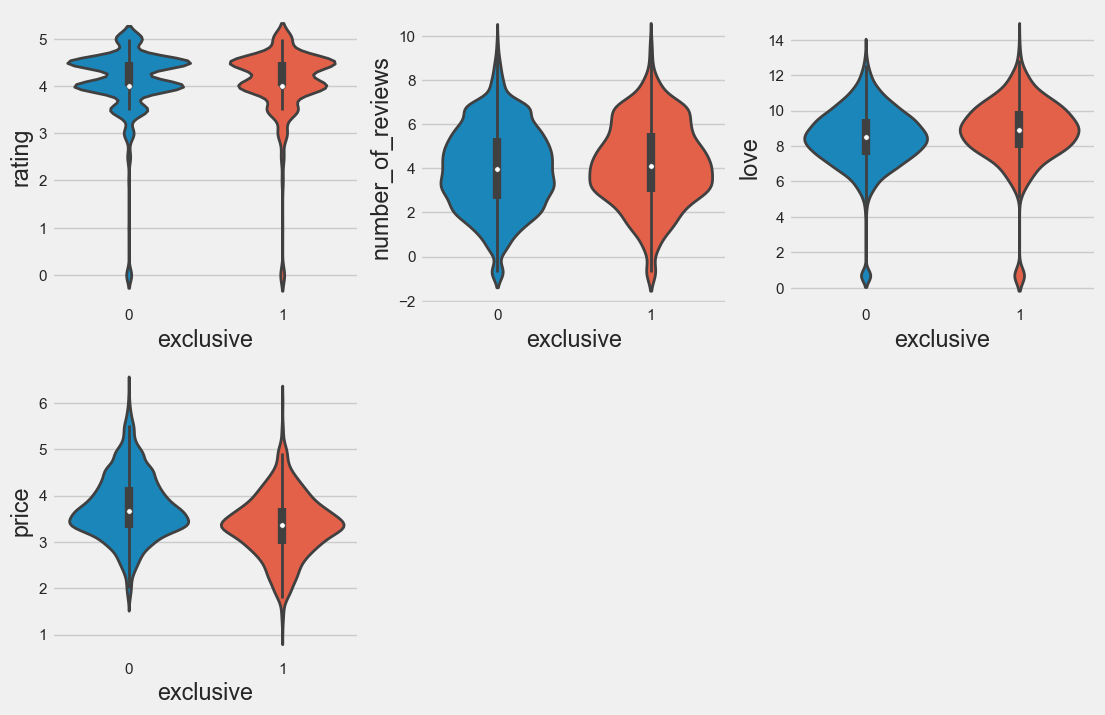

In [13]:
import math

plt.figure(figsize=(12, 8))
for i in range (0, len(nums)):
    plt.subplot(math.ceil(len(nums)/3), 3, i+1)
    sns.violinplot(data=x_train, y=nums[i], x=y_train, linewidth=2, orient='v')

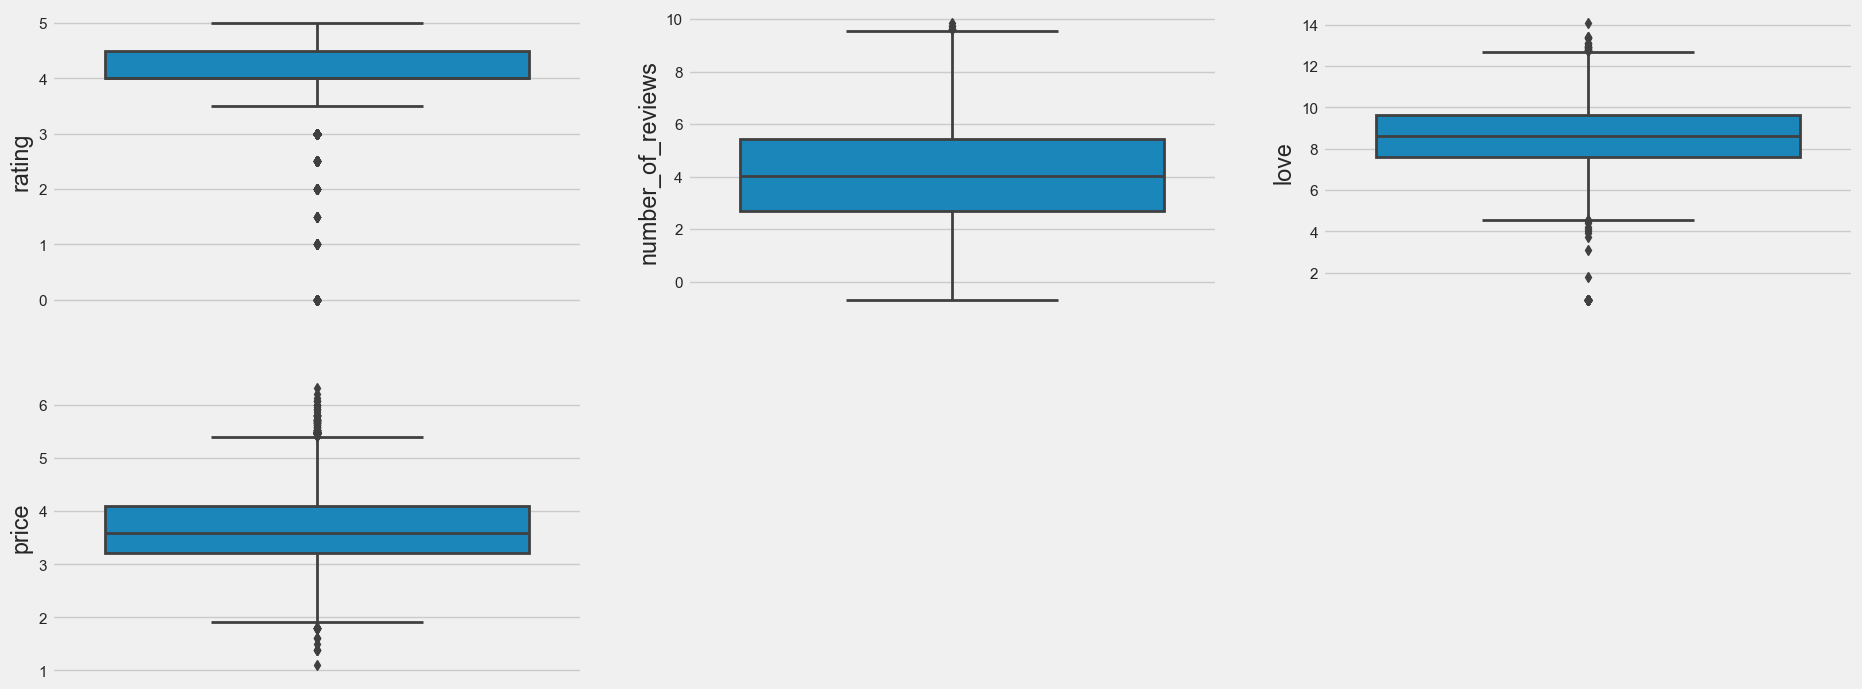

In [14]:
for i in range (0, len(nums)):
    plt.subplot(math.ceil(len(nums)/3), 3, i+1)
    sns.boxplot(data=x_train, y=nums[i], linewidth=2, orient='v')

Note that now almost all the numeric columns appear to have distributions that are quite normal. For normal distributions, we can use the z-score to remove outliers as shown below:

In [15]:
from scipy import stats

# creates function to remove outliers in x_train, and using the x_train parameter to remove corresponding data in y_train
def remove_outliers(x, y, nums, exclude_feature=None):
    """
    Removes outliers from the input dataframe and target variable.

    Parameters:
        x (DataFrame): The input dataframe containing the features.
        y (Series): The target variable.
        nums (list): List of feature names to check for outliers.
        exclude_feature (str or None, optional): The feature name to exclude from outlier removal.
            Defaults to None.

    Returns:
        DataFrame: The input dataframe with outliers removed.
        Series: The target variable with corresponding outliers removed.
    """
    if exclude_feature:
        nums = [num for num in nums if num != exclude_feature]
    
    z_scores = stats.zscore(x[nums])
    outlier_mask = np.abs(z_scores) <= 3
    filtered_x = x[outlier_mask.all(axis=1)]
    filtered_y = y[outlier_mask.all(axis=1)]
    return filtered_x, filtered_y

In [16]:
print("Before removing outlier: ", len(x_train))

# remove outliers
x_train, y_train = remove_outliers(x_train, y_train, nums, exclude_feature='rating')

print("After removing outlier: ", len(x_train))

Before removing outlier:  6400
After removing outlier:  6257


As seen above, we removed approximately ~140 rows that contain outliers based on the z-score method.

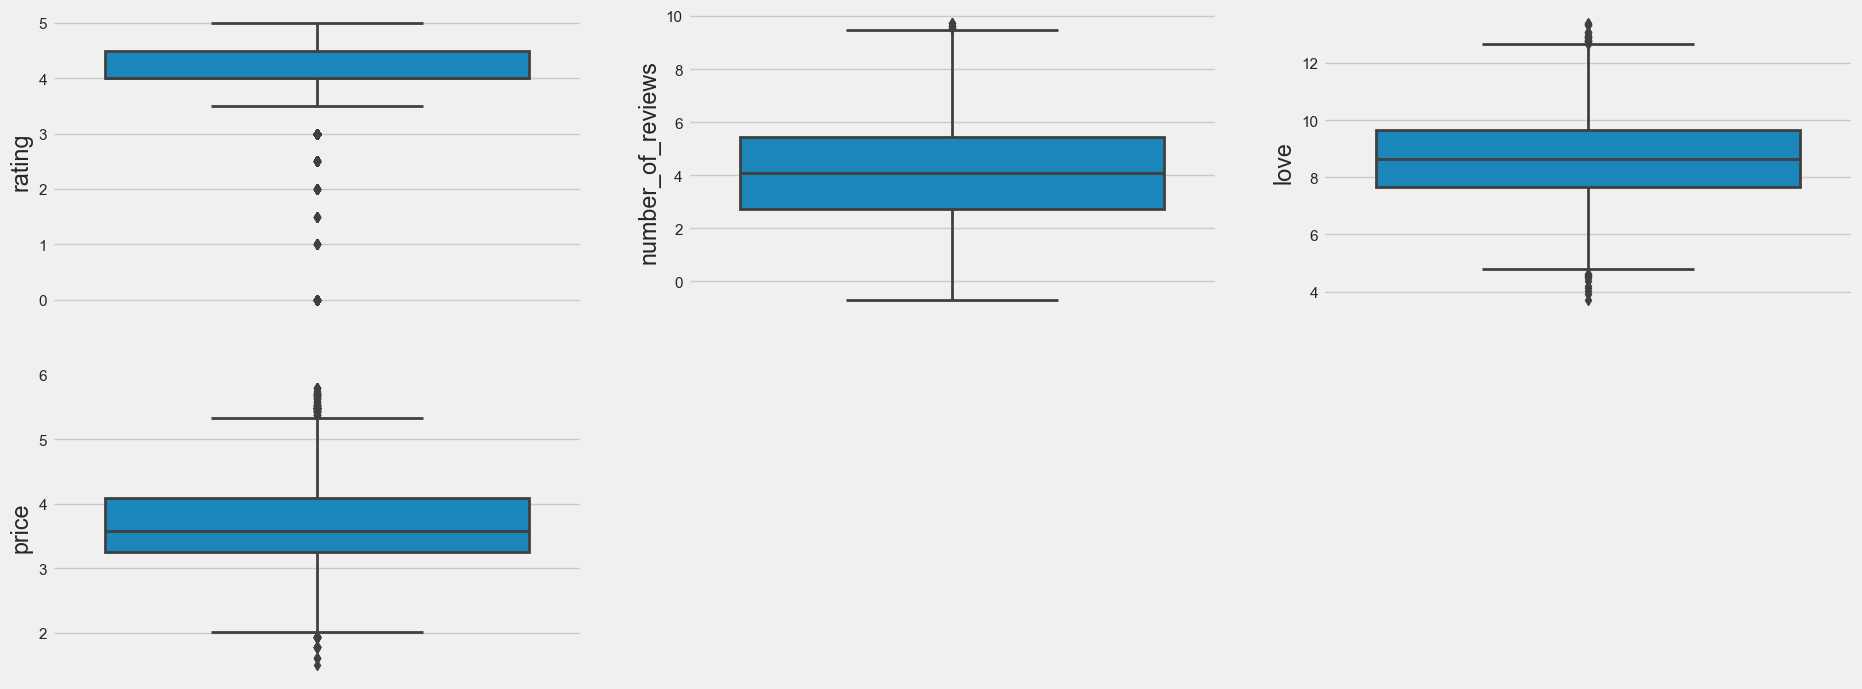

In [17]:
for i in range (0, len(nums)):
    plt.subplot(math.ceil(len(nums)/3), 3, i+1)
    sns.boxplot(data=x_train, y=nums[i], linewidth=2, orient='v')

## Normalization/Standardization

As explained earlier, all our numeric columns now have distributions that are reasonably normal. Therefore, we will proceed with standardizing all our columns as shown below:

Normalization/Standardization will be done to train and test df to ensure that the test data is standardized consistently with the training data.

In [18]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# the column rating will not be standardize as it is an ordinal features (they are not continous numerical feature)
# instead rating column would be more suitable to be one hot encoded
for num in nums:
    if num not in ['rating']:
        # strandardize train data
        x_train[num] = scaler.fit_transform(x_train[[num]])
        
        # Standardize test data using the parameters from the train data
        x_test[num] = scaler.transform(x_test[[num]])

In [19]:
x_train[nums].describe()

,rating,number_of_reviews,love,price
count,6257.000000,6.257000e+03,6.257000e+03,6.257000e+03
mean,4.099249,-1.885090e-16,1.663649e-16,6.830613e-16
std,0.717916,1.000080e+00,1.000080e+00,1.000080e+00
min,0.000000,-2.533746e+00,-3.376399e+00,-3.069387e+00
25%,4.000000,-7.135014e-01,-6.972831e-01,-5.726155e-01
50%,4.000000,-9.472851e-03,-1.820901e-02,-1.093906e-01
75%,4.500000,7.264881e-01,6.667543e-01,6.177478e-01
max,5.000000,2.997054e+00,3.215061e+00,3.027024e+00


In [20]:
x_test[nums].describe()

,rating,number_of_reviews,love,price
count,1600.000000,1600.000000,1600.000000,1600.000000
mean,4.046875,-0.045278,-0.134669,-0.048394
std,0.833359,1.098297,1.394491,1.020843
min,0.000000,-3.012249,-6.624508,-3.878275
25%,4.000000,-0.759832,-0.731014,-0.654340
50%,4.000000,-0.021360,-0.042710,-0.167939
75%,4.500000,0.741427,0.644515,0.582908
max,5.000000,2.812422,3.320575,3.487613


it can be seen now the numerical columns have standard deviation = 1 and mean = 0

## Feature encoding

Based on the EDA, the categorical columns have hundreds of possible values. Despite the dataset's small size (~7500 rows), one-hot encoding was chosen. However, if modeling proves slow, options like removing categories or using label encoding will be considered.

In [21]:
from sklearn.preprocessing import OneHotEncoder

# List of categorical features
cats = ['brand', 'category']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Iterate over categorical features
for cat in cats:
    # Fit the encoder on the training data
    encoder.fit(x_train[cat].values.reshape(-1, 1))

    # Transform on the training set
    x_train_encoded = encoder.transform(x_train[cat].values.reshape(-1, 1))

    # Transform on the test set
    x_test_encoded = encoder.transform(x_test[cat].values.reshape(-1, 1))

    # Get the feature names for the encoded columns
    feature_names = encoder.get_feature_names_out([cat])

    # Create new DataFrames with encoded columns
    x_train_encoded_df = pd.DataFrame(x_train_encoded, columns=feature_names, index=x_train.index)
    x_test_encoded_df = pd.DataFrame(x_test_encoded, columns=feature_names, index=x_test.index)

    # Concatenate the encoded columns with the original dataframes
    x_train = pd.concat([x_train.drop(columns=[cat]), x_train_encoded_df], axis=1)
    x_test = pd.concat([x_test.drop(columns=[cat]), x_test_encoded_df], axis=1)

In [22]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6257 entries, 1467 to 7270
Columns: 445 entries, rating to category_no category
dtypes: float64(445)
memory usage: 21.3 MB


In [23]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 2215 to 6832
Columns: 445 entries, rating to category_no category
dtypes: float64(445)
memory usage: 5.4 MB


it can be seen, the dataset now has hundreds of columns resulting from one-hot encoding of the categorical columns.

## Feature Selection

The dataset has undergone one-hot encoding on its categorical columns, resulting in a substantial increase in the number of columns. Considering the large number of columns, feature selection techniques will be applied to identify the most relevant features for modeling and analysis.

`SelectKbest` `mutual_info_classif` Methods will be used for feature selection. as the dataset are comprised of numerical and categorical feature

In [26]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def select_best_features(x, y, k=15):
    """
    Selects the top 'k' features from a dataframe based on their relevance to the target variable.

    Parameters:
        df (DataFrame)     : The input dataframe containing the features and target variable.
        target_column (str): The name of the target variable column.
        k (int, optional)  : The number of top features to select. Defaults to 15.

    Returns:
        list: A list of the best feature(s) based on their relevance to the target variable.
    """
    # Perform feature selection using SelectKBest and mutual_info_classif
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selector.fit(x, y)
    
    # Get the indices of the k best features
    best_feature_indices = selector.get_support(indices=True)
    
    # Get the names of the best features
    best_features = list(x.columns[best_feature_indices])
    
    return best_features

In [27]:
selected_features = select_best_features(x_train,y_train)
selected_features

['price',
 'brand_CHANEL',
 'brand_COOLA',
 'brand_Ciaté London',
 'brand_Donna Karan',
 'brand_FENTY BEAUTY by Rihanna',
 'brand_Laura Mercier',
 'brand_MAKE UP FOR EVER',
 'brand_NAILS INC.',
 'brand_SEPHORA COLLECTION',
 'brand_Urban Decay',
 'brand_beautyblender',
 'brand_lilah b.',
 'category_Cologne',
 'category_Concealer']

In summary, the selected features indicate that price, brand information (such as Anastasia Beverly Hills, Atelier Cologne, etc.), value_price, and category information (such as Face Brushes, Hair, Spa Tools) are among the most influential factors for predicting the target variable in the given dataset.

## Class imbalance
We can perform class imbalance checking using `value_counts`. It can be seen that the ratio between the positive and negative classes for the `exclusive` column is around `1:3`, indicating that there is class imbalance but not extreme.

In [28]:
y_train.value_counts() / len(y_train) * 100

exclusive
0    74.50855
1    25.49145
Name: count, dtype: float64

# Modeling

The modeling process will begin by evaluating the models without handling imbalances in the dataset to assess their performance. Subsequently, the dataset will be processed using SMOTE (Synthetic Minority Over-sampling Technique) to address the class imbalance. Finally, the performance of different models will be compared to determine the best-performing one.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# initiate model
logreg = LogisticRegression()

# train model
logreg.fit(x_train,y_train)

# predict test set
y_pred = logreg.predict(x_test)

print('accuracy score: ', accuracy_score(y_test, y_pred))
print('precision score: ', precision_score(y_test, y_pred))
print('recall score: ', recall_score(y_test, y_pred))

accuracy score:  0.914375
precision score:  0.8927536231884058
recall score:  0.7549019607843137


In [32]:
from sklearn.neighbors import KNeighborsClassifier

# initiate model
knn = KNeighborsClassifier()

# fit train set to model
knn.fit(x_train, y_train)

# predict test set
y_predknn = knn.predict(x_test)

print('accuracy score: ', accuracy_score(y_test, y_predknn))
print('precision score: ', precision_score(y_test, y_predknn))
print('recall score: ', recall_score(y_test, y_predknn))

accuracy score:  0.85875
precision score:  0.7791411042944786
recall score:  0.6225490196078431


In [38]:
from sklearn.tree import DecisionTreeClassifier

# initiate model
dt = DecisionTreeClassifier()

# fit train set to model
dt.fit(x_train, y_train)

# predict test set
y_preddt = dt.predict(x_test)

print('accuracy score: ', accuracy_score(y_test, y_preddt))
print('precision score: ', precision_score(y_test, y_preddt))
print('recall score: ', recall_score(y_test, y_preddt))

accuracy score:  0.885
precision score:  0.7718446601941747
recall score:  0.7794117647058824


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    y_pred_proba = model.predict_proba(x_test)
    y_pred_proba_train = model.predict_proba(x_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    
    score = cross_validate(model, x, y, cv=5, scoring='recall_score', return_train_score=True)
    print('recall (crossval train): '+ str(score['train_score'].mean()))
    print('recall (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())